In [1]:
#from autograd.scipy.stats import norm 
#from autograd.scipy.stats import gamma
#import autograd.numpy as np
from scipy.stats import norm
from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, unique, Column, hstack, vstack
#from autograd import grad
from xdgmm import XDGMM
#from autograd import hessian
from scipy.optimize import minimize
import matplotlib as mpl

In [2]:
#import autograd.numpy as np
#import autograd.numpy.linalg as npla
#import autograd.scipy.misc as scpm
import scipy.misc as scpm
#import scipy.special.logsumexp as logsumexp

def mog_logprob(x, means, icovs, lndets, pis):
    """ compute the log likelihood according to a mixture of gaussians
        with means  = [mu0, mu1, ... muk]
             icovs  = [C0^-1, ..., CK^-1]
             lndets = ln [|C0|, ..., |CK|]
             pis    = [pi1, ..., piK] (sum to 1)
        at locations given by x = [x1, ..., xN]
    """
    xx = np.atleast_2d(x)
    D  = xx.shape[1]
    centered = xx[:,:,np.newaxis] - means.T[np.newaxis,:,:]
    solved   = np.einsum('ijk,lji->lki', icovs, centered)
    logprobs = - 0.5*np.sum(solved * centered, axis=1) - (D/2.)*np.log(2*np.pi) \
               - 0.5*lndets + np.log(pis)
    logprob  = scpm.logsumexp(logprobs, axis=1)
    if np.isscalar(x) or len(x.shape) == 1:
        return logprob[0]
    else:
        return logprob


In [19]:
def predicted_color(A, c, alpha=0.3):
    return c + A*alpha

def predicted_magnitude(A, M, d, beta=0.16):
    return M + A*beta + 5.*np.log10(d*1e3/10.)

def logjoint(theta, chat, mhat, varpihat, sigmac, sigmam, sigmavarpi, pis, means, icovs, lndets):
    lnA, M, c, lnd = theta
    A, d      = np.exp(lnA), np.exp(lnd)
    lnp_c     = norm.logpdf(chat, predicted_color(A, c), sigmac)
    lnp_m     = norm.logpdf(mhat, predicted_magnitude(A, M, d), sigmam)
    lnp_varpi = norm.logpdf(varpihat, 1./d, sigmavarpi)
    lnp_Mc    = mog_logprob(np.array([c,M]), means, icovs, lndets, pis)

    if (A >= 0) & (A < 5):
        lnp_A = 0
    else:
        lnp_A = -np.inf
    
    if (d > 0) & (d < 10): 
        lnp_d = 0
    else: 
        lnp_d = -np.inf

    string = 'p(c):{0} p(m):{1} p(varpi):{2} p(Mc):{3} p(A):{4} p(d):{5}'.format(lnp_c, lnp_m, lnp_varpi, lnp_Mc, lnp_A, lnp_d)
    #print(string)
    return np.sum([lnp_c, lnp_m, lnp_varpi, lnp_Mc, lnp_A, lnp_d])

In [4]:
def plotXdgmm(xdgmm, ax, c='k', lw=1, label='prior', step=0.001):
    ts = np.arange(0, 2. * np.pi, step) #magic
    amps = xdgmm.weights
    mus = xdgmm.mu
    Vs = xdgmm.V
    for gg in range(xdgmm.n_components):
        if amps[gg] == np.max(amps):
            label=label
        else:
            label=None
        w, v = np.linalg.eigh(Vs[gg])
        points = np.sqrt(w[0]) * (v[:, 0])[:,None] * (np.cos(ts))[None, :] + \
                 np.sqrt(w[1]) * (v[:, 1])[:,None] * (np.sin(ts))[None, :] + \
                 mus[gg][:, None]
        ax.plot(points[0,:], points[1,:], c, lw=lw, alpha=amps[gg]/np.max(amps), rasterized=True, label=label)

def plotgaussian1sigma(ax, mu, V, c='k', lw=1, label='prior', step=0.001, alpha=1.0):
    ts = np.arange(0, 2. * np.pi, step) #magic
    w, v = np.linalg.eigh(V)
    points = np.sqrt(w[0]) * (v[:, 0])[:,None] * (np.cos(ts))[None, :] + \
             np.sqrt(w[1]) * (v[:, 1])[:,None] * (np.sin(ts))[None, :] + \
             mu[:, None]
    ax.plot(points[0,:], points[1,:], c, lw=lw, alpha=alpha, rasterized=True, label=label)
    return points

In [6]:
ncomp = 256
filename = 'rjce_fullcmd_sfd_0.01_{0}G.fits'.format(ncomp)
xdgmm = XDGMM(filename=filename, method='Bovy')
lndets = np.array([np.linalg.slogdet(s)[1] for s in xdgmm.V])
icovs = np.array([np.linalg.inv(s) for s in xdgmm.V])
means = xdgmm.mu
pis = xdgmm.weights


In [7]:
datahigh = Table.read('dustHighLat-result.fits.gz')
datalow = Table.read('dustLowLat-result.fits.gz')
data = vstack((datahigh, datalow))

In [8]:
mhat = data['w2mpro']
w2hat = data['w2mpro']
hhat = data['h_m']
chat = data['h_m'] - data['w2mpro']
varpihat = data['parallax']
sigmac = np.sqrt(data['h_msigcom']**2 + data['w2mpro_error']**2.)
sigmam = data['w2mpro_error']
sigmavarpi = data['parallax_error']
sigmaw2 = data['w2mpro']
sigmah = data['h_msigcom']

In [9]:
sample = xdgmm.sample(int(len(chat)/10))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + arg

Dust: -2.583  Absmag: 4.298  color: 0.088  distance: -0.119


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


Dust: -1.743  Absmag: 3.264  color: 0.066  distance: -0.767
Dust: -1.350  Absmag: 5.061  color: 0.289  distance: -0.860


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


Dust: -18.670  Absmag: 2.930  color: 0.010  distance: 0.369
Dust: -2.223  Absmag: 3.140  color: 0.064  distance: 0.234
Dust: -19.295  Absmag: 1.192  color: 0.071  distance: -0.145


/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


Dust: -2.976  Absmag: 3.508  color: 0.068  distance: -0.689
Dust: -0.673  Absmag: 4.408  color: 0.183  distance: -0.756


/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


Dust: -0.203  Absmag: 4.484  color: 0.110  distance: -0.745
Dust: -0.213  Absmag: 4.081  color: 0.080  distance: -0.287


/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.log

Dust: 0.649  Absmag: 2.496  color: -1.235  distance: -0.679
Dust: 0.259  Absmag: 3.187  color: -0.994  distance: -0.827


/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.log

Dust: -19.725  Absmag: 3.486  color: 0.068  distance: -0.625
Dust: -2.777  Absmag: 3.806  color: 0.073  distance: -0.274


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


Dust: -4.759  Absmag: 2.555  color: 0.060  distance: 0.240


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated

Dust: -2.033  Absmag: 2.828  color: 0.064  distance: -0.184
Dust: -0.411  Absmag: 5.563  color: 0.327  distance: -0.984
Dust: -17.101  Absmag: 3.790  color: 0.072  distance: -0.114
Dust: -16.861  Absmag: 2.713  color: 0.010  distance: 0.221


/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.log

Dust: -2.800  Absmag: 4.564  color: 0.126  distance: -1.354


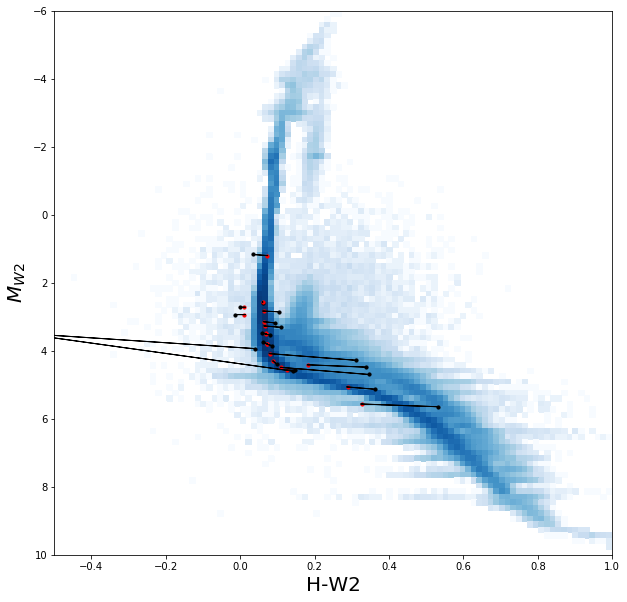

In [20]:
method= None #'L-BFGS-B'
i = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

xlim = [-0.5, 1.0]
ylim = [-6, 10]
nbins = 100
xbins = np.linspace(xlim[0], xlim[1], nbins)
ybins = np.linspace(ylim[0], ylim[1], nbins)

H, xe, ye = np.histogram2d(sample[:,0], 
                           sample[:,1], 
                           bins=(xbins, ybins))
im = ax.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))
im.set_rasterized(True)


for i in range(0, 20):
    args = (chat[i], mhat[i], varpihat[i], sigmac[i], sigmam[i], sigmavarpi[i], pis, means, icovs, lndets)
    theta_0 = np.array([0.1, 1., 0.08, 0.5])
    #                     A, M, c, d = theta

    obj = lambda *args: -1.*logjoint(*args)
    res = minimize(obj, theta_0, args=args, method=method) #, jac=gobj)
    theta_hat = res.x
    print('Dust: {0:.3f}  Absmag: {1:0.3f}  color: {2:0.3f}  distance: {3:0.3f}'.format(theta_hat[0], 
                                                                                        theta_hat[1],
                                                                                        theta_hat[2], 
                                                                                        theta_hat[3]))

    am = mhat[i] - 5.*np.log10(1./(varpihat[i]/1e3*10))
    ax.scatter(chat[i], am, s=10, c='black')
    ax.scatter(theta_hat[2], theta_hat[1], c='red', s=10)
    plt.arrow(chat[i], am, theta_hat[2] - chat[i], theta_hat[1] - am)

    ax.set_xlabel('H-W2', fontsize=20)
    ax.set_ylabel('$M_{W2}$', fontsize=20)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim[::-1])

plt.savefig('posteriors.png', rasterized=True)

In [12]:
xx, yy = np.meshgrid(xe, ye)
values = np.zeros(len(xx.flatten()))
for i, (x, y) in enumerate(zip(xx.flatten(), yy.flatten())):
    values[i] = mog_logprob(np.array([x, y]), means, icovs, lndets, pis)
values[values < -10] = -10

In [13]:
from scipy.integrate import simps
simps(simps(np.exp(values).reshape(xx.shape), ye), xe)

1.041071486714874

Dust: 0.817+/-0.537  Absmag: 5.067+-0.096  color: 1.151+-0.152  distance: 0.332+-0.004
Dust: 0.058+/-nan  Absmag: 1.754+-nan  color: 0.047+-nan  distance: 0.223+-nan
Dust: 0.000+/-0.551  Absmag: 1.180+-0.106  color: 0.163+-0.155  distance: 1.662+-0.034
Dust: 0.090+/-0.139  Absmag: 3.084+-0.046  color: 0.128+-nan  distance: 0.819+-0.014
Dust: 0.232+/-0.179  Absmag: 3.148+-0.036  color: 0.064+-0.008  distance: 0.687+-0.010
Dust: 0.301+/-0.180  Absmag: 2.866+-0.088  color: 0.223+-nan  distance: 1.289+-0.044
Dust: 0.019+/-0.219  Absmag: 2.802+-0.142  color: 0.063+-0.011  distance: 1.407+-0.071
Dust: 0.073+/-0.546  Absmag: 2.665+-0.112  color: -0.006+-0.153  distance: 1.228+-0.033
Dust: 0.084+/-0.074  Absmag: 4.081+-0.065  color: -0.005+-nan  distance: 0.474+-0.006
Dust: 0.503+/-0.188  Absmag: 1.320+-0.057  color: 0.072+-0.005  distance: 1.079+-0.017
Dust: 0.203+/-0.175  Absmag: 2.105+-0.027  color: 0.061+-0.005  distance: 1.037+-0.016
Dust: 0.092+/-0.201  Absmag: 2.978+-0.090  color: 0.159

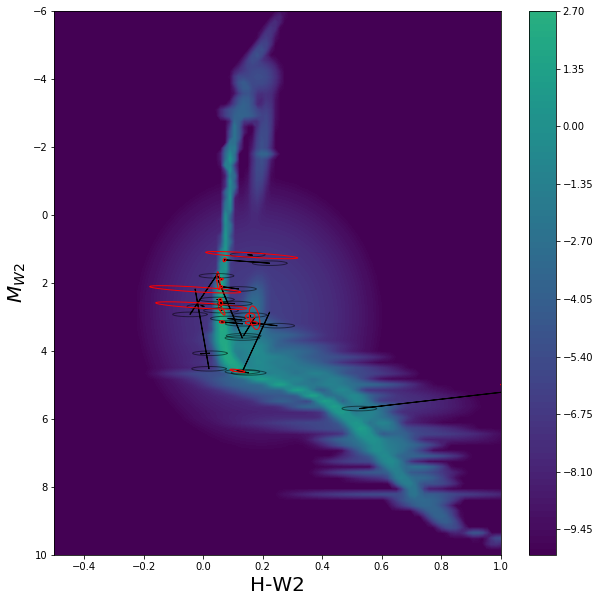

In [14]:
method='L-BFGS-B'
i = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

xlim = [-0.5, 1.0]
ylim = [-6, 10]
nbins = 100
xbins = np.linspace(xlim[0], xlim[1], nbins)
ybins = np.linspace(ylim[0], ylim[1], nbins)

im = ax.contourf(xx, yy, values.reshape(xx.shape), 100, vmin=-10, vmax=10)
fig.colorbar(im,ax=ax)
#im.set_rasterized(True)


for j in range(0, 20):
    i = np.random.randint(0, len(bright))
    args = (chat[bright[i]], mhat[bright[i]], varpihat[bright[i]], sigmac[bright[i]], sigmam[bright[i]], sigmavarpi[bright[i]], pis, means, icovs, lndets, xdgmm)
    theta_0 = np.array([0.1, 2., 0.08, 1.0])

    obj = lambda *args: -1.*logjoint(*args)
    gobj = grad(obj)
    hobj = hessian(obj)
    res = minimize(obj, theta_0, args=args, method=method, jac=gobj)
    theta_hat = res.x
    sigma_hat = np.linalg.inv(hobj(theta_hat, chat[bright[0]], mhat[bright[0]], 
                                   varpihat[bright[0]], sigmac[bright[0]], sigmam[bright[0]], sigmavarpi[bright[0]], pis, means, icovs, lndets, xdgmm))

    print('Dust: {0:.3f}+/-{1:0.3f}  Absmag: {2:0.3f}+-{3:0.3f}  color: {4:0.3f}+-{5:0.3f}  distance: {6:0.3f}+-{7:0.3f}'.format(theta_hat[0], np.sqrt(sigma_hat[0,0]), 
                                                                                  theta_hat[1], np.sqrt(sigma_hat[1,1]),
                                                                                  theta_hat[2], np.sqrt(sigma_hat[2,2]),
                                                                                  theta_hat[3], np.sqrt(sigma_hat[3,3])))


    am = mhat[bright[i]] - 5.*np.log10(1./(varpihat[bright[i]]/1e3*10))
    #plotXdgmm(xdgmm, ax[1], lw=2)
    V = np.zeros((2,2))
    V[0,0] = sigmac[0]**2.
    V[1,1] = sigmam[0]**2 + sigmavarpi[0]**2
    p = plotgaussian1sigma(ax, np.array([chat[bright[i]], am]), V, alpha=0.5) 
    V = np.zeros((2,2))
    V[0,0] = sigma_hat[2,2]
    V[1,0] = sigma_hat[2,1]
    V[0,1] = sigma_hat[1,2]
    V[1,1] = sigma_hat[1,1]
    p = plotgaussian1sigma(ax, np.array([theta_hat[2], theta_hat[1]]), V, c='red')
    #A, M, c, d = theta

    plt.arrow(chat[bright[i]], am, theta_hat[2] - chat[bright[i]], theta_hat[1] - am)

    ax.set_xlabel('H-W2', fontsize=20)
    ax.set_ylabel('$M_{W2}$', fontsize=20)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim[::-1])
    #ax.set_title(l, fontsize=20)
plt.savefig('posteriors.png', rasterized=True)


In [ ]:
p(c):-6.217428764152867 p(m):-49.720487084570664 p(varpi):-2857.7659418150315 p(Mc):-4.268768121303194 p(A):-0.1 p(d):-1.0
p(c):-21.72984608241658 p(m):-533.6503819365388 p(varpi):-1937.6469227094653 p(Mc):-7.56569717726221 p(A):-0.053345126719801426 p(d):-0.7029512825086909                        

In [ ]:
lnp_c,             lnp_m,                lnp_varpi,           lnp_Mc,             lnp_A,             lnp_d
2.1611949728028126 -90.33760374614414 -21.50742721543208 -12.24564139236691 -0.9239385332046727 -3.2265236261987185
-8.424173677612075 -14.177497800096212 -37.45983009577268 4.6380018062232455 -0.9675665739445588 -3.2262035033735943


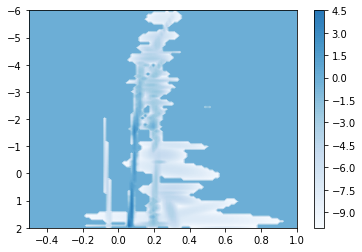

In [132]:



plt.contourf(xx, yy, values.reshape(xx.shape), 100, vmin=-10, vmax=10, cmap=plt.get_cmap('Blues'))
plt.colorbar()
plt.gca().invert_yaxis()


In [97]:
np.exp(values)

array([1.16418836e-70, 4.14685565e-68, 1.31460877e-65, ...,
       4.95010911e-06, 4.42437444e-06, 3.93845198e-06])

NameError: name 'sigma_hat' is not defined

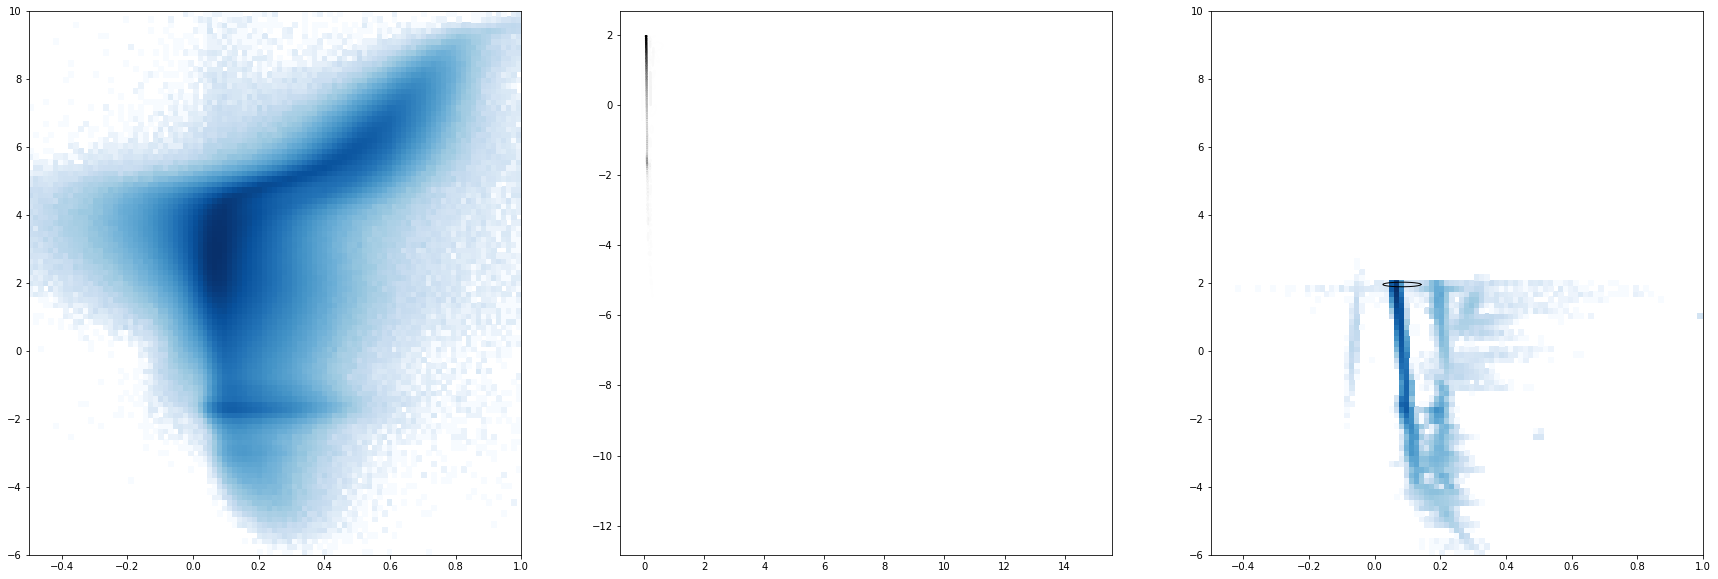

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

xlim = [-0.5, 1.0]
ylim = [-6, 10]
nbins = 100
xbins = np.linspace(xlim[0], xlim[1], nbins)
ybins = np.linspace(ylim[0], ylim[1], nbins)

for c, ab, a in zip([chat, sample[:,0]], [absmag, sample[:,1]], [ax[0], ax[2]]):
    H, xe, ye = np.histogram2d(c, 
                           ab, 
                           bins=(xbins, ybins))
    im = a.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
    im.set_rasterized(True)

plotXdgmm(xdgmm, ax[1], lw=2)
V = np.zeros((2,2))
V[0,0] = sigmac[0]**2.
V[1,1] = sigmam[0]**2 + sigmavarpi[0]**2
p = plotgaussian1sigma(ax[2], np.array([chat[bright[i]], mhat[bright[i]] - 5.*np.log10(1./(varpihat[bright[i]]/1e3*10))]), V) 
V = np.zeros((2,2))
V[0,0] = sigma_hat[2,2]
V[1,0] = sigma_hat[2,1]
V[0,1] = sigma_hat[1,2]
V[1,1] = sigma_hat[1,1]
p = plotgaussian1sigma(ax[2], np.array([theta_hat[2], theta_hat[1]]), V)
#A, M, c, d = theta
labels = ['data', 'gaussian mixture', 'samples']

for a , l in zip(ax, labels):
    a.set_xlabel('H-W2', fontsize=20)
    a.set_ylabel('$M_{W2}$', fontsize=20)
    a.set_xlim(xlim)
    a.set_ylim(ylim[::-1])
    a.set_title(l, fontsize=20)

In [ ]:
theta_hat

In [ ]:
print(p)

In [81]:
plot gmm
plot chat, mhat-> Mhat
plot c, M
plot arrow


(0.09899984741210943,
 14.061,
 1.165034815943981,
 0.058051702036715704,
 0.039,
 0.055317342303344876,
 array([6.33139839e-04, 1.86296822e-03, 5.88131355e-03, 2.08169037e-03,
        3.98768584e-03, 3.20725078e-04, 4.19642460e-03, 9.39181768e-04,
        2.00968955e-03, 3.88977587e-03, 3.18107534e-03, 1.24670535e-03,
        4.19633828e-06, 1.54414486e-02, 3.78180113e-04, 4.04491059e-03,
        6.09542552e-03, 7.69332793e-04, 2.12884917e-03, 1.32317844e-03,
        8.41272472e-03, 2.30433187e-04, 2.07959393e-03, 8.39369688e-06,
        8.47595911e-05, 1.03095756e-02, 1.12067270e-02, 1.09590028e-02,
        4.19633828e-06, 3.02233138e-03, 2.41416290e-03, 1.25756630e-02,
        4.24724977e-05, 2.96082477e-03, 2.61581569e-03, 2.42697053e-03,
        4.19890549e-03, 4.65168304e-03, 4.96451001e-03, 1.00604227e-02,
        4.56487778e-03, 1.51879457e-02, 1.91853789e-03, 1.93822422e-04,
        4.04683459e-03, 1.91932535e-02, 4.19633828e-06, 3.03952744e-04,
        5.10863492e-03, 7.25615